In [71]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta


dask.config.set(**{'array.slicing.split_large_chunks': True})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notes:

GFDL: 1pct and esm pi-control start from year 0001

UKESM1: 1pct starts in 1850 and pi-control starts in 1960, move 1pct to start in 1960

MIROC: both start from 1850

NORESM2: 1pct from 0001 pi-control from 1600-- move 1pct to 1600

ACCESS: 1pct and pi-control from 0101

CANESM5_r1p1: 1pct 1850, pi-control 5201, move 1pct to 5201

CANESM5_r1p2: 1pct 1850, pi-control 5550, move 1pct to 5550


## Import data and calculate GF

In [72]:
model_run_4x_dict = utils.model_run_4x_dict
model_run_control_dict = utils.model_run_picontrol_dict


In [73]:
model_run_4x_dict

{'UKESM1_r1': 'UKESM1-0-LL_abrupt-4xCO2_r1i1p1f2*',
 'MIROC': 'MIROC-ES2L_abrupt-4xCO2_r1i1p1f2_gn*',
 'NORESM2': 'NorESM2-LM_abrupt-4xCO2_r1i1p1f1*',
 'ACCESS': 'ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1*',
 'CANESM5_r1p2': 'CanESM5_abrupt-4xCO2_r1i1p2f1_gn*',
 'CANESM5_r1p1': 'CanESM5_abrupt-4xCO2_r1i1p1f1_gn*'}

In [74]:
fg_co2_4x = {}
fg_co2_pictrl = {}
nbp_4x = {}
nbp_pictrl = {}
co2_4x = {}
co2_pictrl = {}
areacello = {}
areacella = {}

In [75]:
for m in model_run_4x_dict.keys():
    print(m)
    print('load 4x run')
    print('fg')
    fg_co2_4x[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_4x_dict[m]}', use_cftime=True) #kgC/m2/s
    print('nbp')
    if m == 'UKESM1_r1' or m == 'MIROC' or m == 'NORESM2' or m == 'ACCESS' or m == 'CANESM5_r1p2' or m == 'CANESM5_r1p1':
        nbp_4x[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_4x_dict[m]}', use_cftime=True) #kgC/m2/s
    if m == 'UKESM1_r1':
        co2_4x[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_4x_dict[m]}', use_cftime=True) #kg
    
    

UKESM1_r1
load 4x run
fg
nbp
MIROC
load 4x run
fg
nbp
NORESM2
load 4x run
fg
nbp
ACCESS
load 4x run
fg
nbp
CANESM5_r1p2
load 4x run
fg
nbp
CANESM5_r1p1
load 4x run
fg
nbp


In [78]:
for m in model_run_control_dict.keys():
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4') #kg/m2/s 
    
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kgC/m2/s 

    if m == 'UKESM1_r1' or m == 'NORESM2' or m == 'GFDL':
        co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg
    
    areacello[m] = xr.open_mfdataset(f'cmip6_data/areacello_Ofx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')
    areacella[m] = xr.open_mfdataset(f'cmip6_data/areacella_fx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')


UKESM1_r1
load pi control run
MIROC
load pi control run
NORESM2
load pi control run
ACCESS
load pi control run
GFDL
load pi control run
CANESM5_r1p2
load pi control run
CANESM5_r1p1
load pi control run


In [89]:
nbp_pictrl['ACCESS']

<xarray.Dataset>
Dimensions:    (time: 12000, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 1100-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(6000, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(6000, 192, 2), meta=np.ndarray>
    nbp        (time, lat, lon) float32 dask.array<chunksize=(6000, 145, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    creation_date:          2019-11-12T19:31:59Z
    ...                     ...
    variable_id:            nbp
    variant_label:          r1i1p1f1
    version:                v20191112
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/ea8201eb-720d-414c-a0b3-4c6edb62a58c
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [87]:
for m in co2_pictrl.keys():
    print(co2_pictrl[m].isel(time = 0)['co2mass'].values)

2214839069966336.0
2217062923501568.0
1453596113633280.0


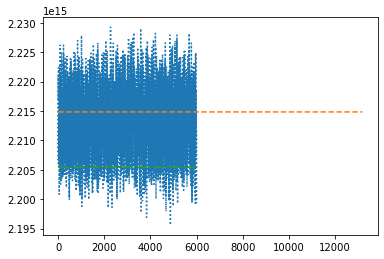

In [101]:
plt.plot(co2_pictrl['GFDL']['co2mass'], linestyle = ':')
plt.plot(co2_pictrl['UKESM1_r1']['co2mass'], linestyle = '--')
plt.plot(co2_pictrl['NORESM2']['co2mass']*1.5172413793, linestyle = '-.')


In [107]:
kgCO2_to_kgC = 1/3.67

#find 3 times the initial co2 concentration
t = 1 #years
three_ci = co2_pictrl['NORESM2']['co2mass'].mean(dim = 'time').values*1.5172413793*3/(t)
three_ci*= kgCO2_to_kgC
three_ci

1802825042577700.5

In [108]:


#convert kg to kg/year
for m in ['UKESM1_r1']:
    seconds_per_yr = 60*60*24*365
    co2_4x[m]['G_atm'] = co2_4x[m]['co2mass'].diff('time')/(co2_4x[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_4x[m]['G_atm'] *= kgCO2_to_kgC
    co2_4x[m]['G_atm'].attrs = {'units':'kgC'}
    
for m in ['UKESM1_r1']:
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_pictrl[m]['G_atm'] *= kgCO2_to_kgC
    co2_pictrl[m]['G_atm'].attrs = {'units':'kgC'}

In [109]:
## fix the times so that they line up according to the notes above
m = 'NORESM2'
nbp_pictrl[m]['time'] = nbp_pictrl[m]['time'] -timedelta(365*1599)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl[m]['time'] - timedelta(365*1599)
# co2_pictrl[m]['time'] = co2_pictrl[m]['time'] - timedelta(365*1599)
# co2_4x[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)
# co2_pictrl[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)


m = 'UKESM1_r1'
nbp_pictrl[m]['time'] = nbp_pictrl['UKESM1_r1']['time'] - timedelta(360*110)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['UKESM1_r1']['time'] - timedelta(360*110)
co2_pictrl[m]['time'] = co2_pictrl['UKESM1_r1']['time'] - timedelta(360*110)

m = 'CANESM5_r1p2'
nbp_pictrl[m]['time'] = nbp_pictrl['CANESM5_r1p2']['time']- timedelta(365*3700)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['CANESM5_r1p2']['time']- timedelta(365*3700)

m = 'CANESM5_r1p1'
nbp_pictrl[m]['time'] = nbp_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)


In [110]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

#replace GFDL areacello with this-- areacello doesn't match up

areacello['GFDL'] = A

In [111]:
fg_co2 = {}
nbp = {}

for m1 in model_run_4x_dict.keys():
    m2 = m1
    fg_co2[m1] = fg_co2_4x[m1] - fg_co2_pictrl[m2]
    if m1 != 'GFDL':
        nbp[m1] = nbp_4x[m1] - nbp_pictrl[m2]
    
    if m2 == 'GFDL':
        fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*areacello[m2]
    else:
        fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*areacello[m2]['areacello']
    if m1 != 'GFDL':
        nbp[m1]['nbp'] = nbp[m1]['nbp']*seconds_per_yr*areacella[m2]['areacella']

In [112]:
co2_dif = {}
for m1 in co2_4x.keys():
    m2 = m1
    print(m1, m2)
    co2_dif[m1] = co2_4x[m1]['G_atm'] - co2_pictrl[m2]['G_atm'] #kg/yr

UKESM1_r1 UKESM1_r1


In [113]:
#total sinks
emis_sinks = {}
for m in nbp.keys():
    if 'lat' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon'])
    elif 'i' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['i','j'])
    elif 'x' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['x','y'])

In [114]:
#fix the times to all be the same, weight by month and take the mean

for m in nbp.keys():    
    times = emis_sinks[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [115]:
G_atm = {}
for m in co2_dif.keys():    
    times = co2_dif[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', co2_dif[m]['time'].values)]).astype('float')
    G_atm[m] =  (co2_dif[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [116]:
## add in the pulse, which is not accounted for bc it is infinite so we discretize it and make it as 3ci where ci is the initial pictrl concentration

In [117]:
G_atm['UKESM1_r1'].loc[dict(year = 1850)] = three_ci

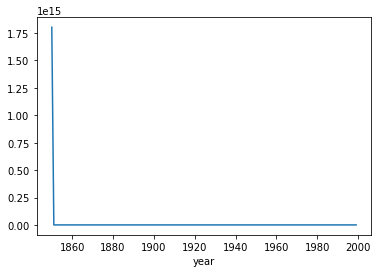

In [118]:
G_atm['UKESM1_r1'].plot()

In [119]:
for m in emis_sinks.keys():
    emis_sinks[m]['year'] = np.arange(0, len(emis_sinks[m]['year']))

In [120]:
for m in G_atm.keys():
    G_atm[m]['year'] = np.arange(0, len(G_atm[m]['year']))

In [121]:
def diff_lists(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))  # or return list(set(list1) ^ set(list2))

emis_co2 = {}
for m in G_atm.keys():
        emis_co2[m] = G_atm[m] + emis_sinks[m]

for m in diff_lists(emis_sinks.keys(), G_atm.keys()):
        emis_co2[m] = G_atm['UKESM1_r1'] + emis_sinks[m] #use UKESM1_r1 co2 mass bc these runs don't have their own
    

In [122]:
emis_co2_GtC = {}
kg_to_Gt = 1e-12

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_to_Gt
    

In [123]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')

# Save out CO2 emissions

In [125]:
emis_co2_GtC_ds.to_netcdf('4x_emis_profile_full.nc4')


## Plots

ValueError: 'j' not found in array dimensions ('time', 'y', 'x')

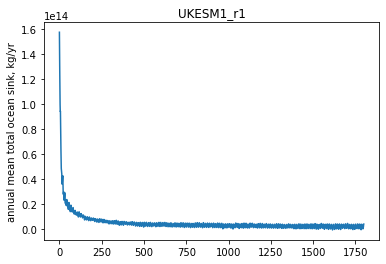

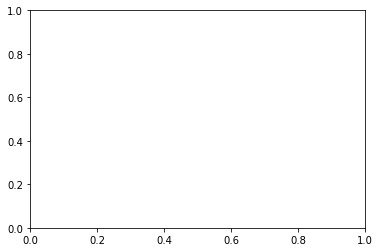

In [28]:
for m in fg_co2.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['j','i']))
    plt.ylabel('annual mean total ocean sink, kg/yr')
    plt.title(m)

In [ ]:
for m in nbp.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

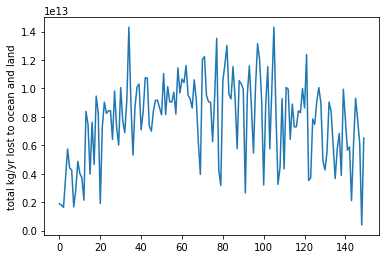

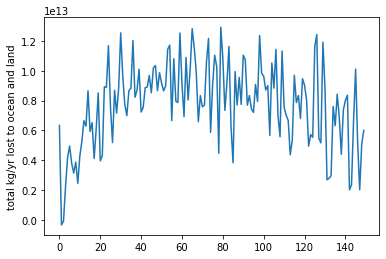

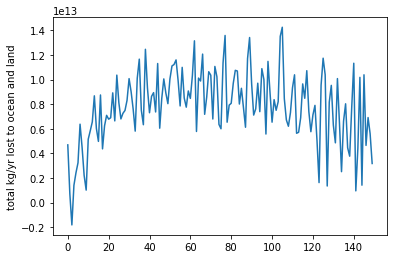

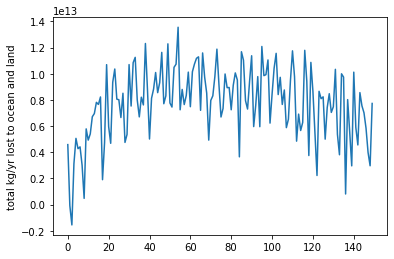

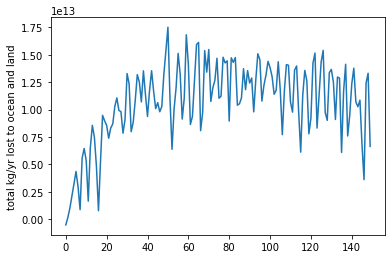

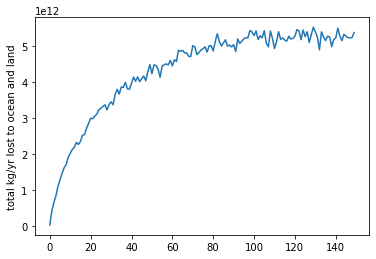

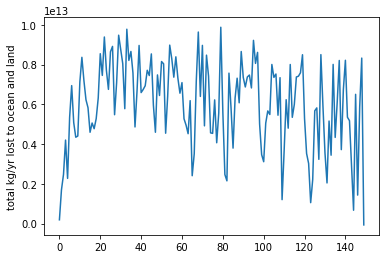

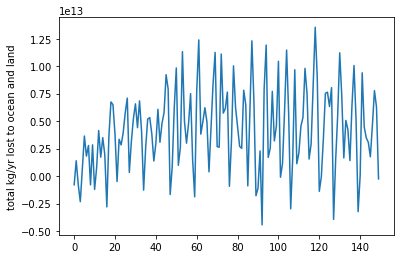

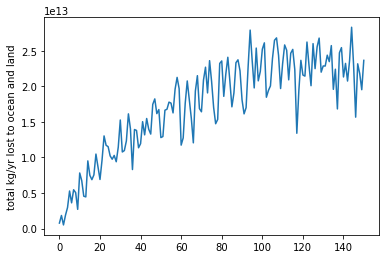

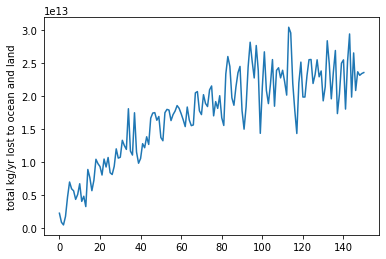

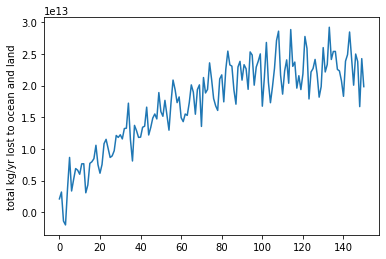

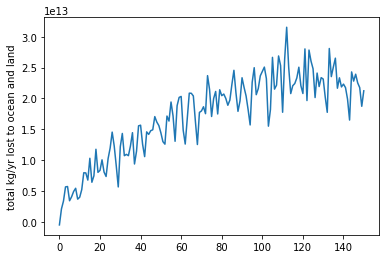

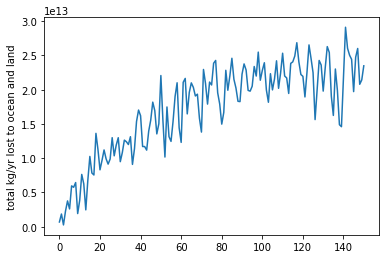

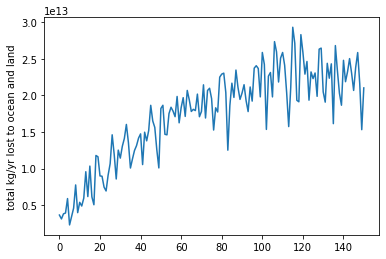

In [23]:
for m in emis_sinks.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

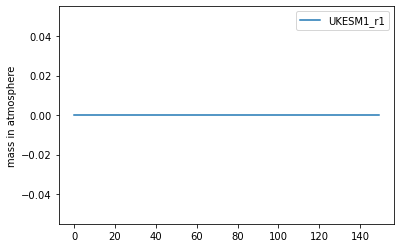

In [29]:
fig, ax = plt.subplots()
for m in G_atm.keys():
    plt.plot(G_atm[m], label = m)
    plt.ylabel('mass in atmosphere')
    plt.legend()

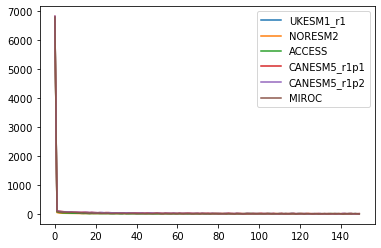

In [43]:
for m in emis_co2_GtC_ds.model.values:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()